In [1]:
!pip install pygraphviz

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [14]:
class ScalarTmp:
    
    def __init__(self, value, prevs=[], op=None, label=''):
        # 定义节点的值
        self.value = value
        # 定义直接的前序节点
        self.prevs = prevs
        # 定义运算符号：op或者变量名label
        self.op = op
        self.label = label
        self.grad = 0.0
        self.grad_wrt = {}
        
    def __repr__(self):
        return f'{self.value} | {self.op} | {self.label}'
        
    def __add__(self, other):
        # self + other触发这个函数
        value = self.value + other.value
        prevs = [self, other]
        output = ScalarTmp(value, prevs, op='+')
        output.grad_wrt[self] = 1
        output.grad_wrt[other] = 1
        return output
    
    def __mul__(self, other):
        # self * other触发这个函数
        value = self.value * other.value
        prevs = [self, other]
        output = ScalarTmp(value, prevs, op='*')
        output.grad_wrt[self] = other.value
        output.grad_wrt[other] = self.value
        return output

In [5]:
a = ScalarTmp(1.0, label='a')
b = ScalarTmp(2.0, label='b')
c = a + b
c

3.0 | + | 

In [19]:
from graphviz import Digraph

def _trace(root):
    # 遍历计算图中的所有点和边
    nodes, edges = set(), set()
    def _build(v):
        if v not in nodes:
            nodes.add(v)
            for prev in v.prevs:
                edges.add((prev, v))
                _build(prev)
    _build(root)
    return nodes, edges
   

def draw_graph(root, direction='forward'):
    nodes, edges = _trace(root)
    rankdir = 'BT' if direction == 'forward' else 'TB'
    graph = Digraph(format='svg', graph_attr={'rankdir': rankdir})
    # 画点
    for node in nodes:
        label = node.label if node.op is None else node.op
        node_attr = f'{{ grad={node.grad:.2f} | value={node.value:.2f} | {label}}}'
        uid = str(id(node))
        graph.node(name=uid, label=node_attr, shape='record')
    # 画边
    for edge in edges:
        id1 = str(id(edge[0]))
        id2 = str(id(edge[1]))
        graph.edge(id1, id2)
    return graph

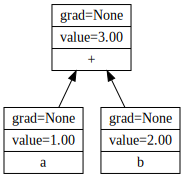

In [7]:
draw_graph(c)

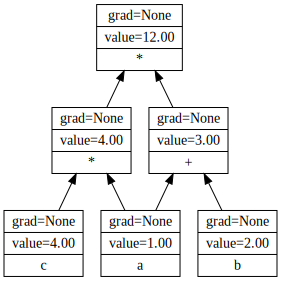

In [16]:
a = ScalarTmp(1.0, label='a')
b = ScalarTmp(2.0, label='b')
c = ScalarTmp(4.0, label='c')
d = a + b
e = a * c
f = d * e
draw_graph(f)

In [9]:
a - b

TypeError: unsupported operand type(s) for -: 'ScalarTmp' and 'ScalarTmp'

In [10]:
# 拓扑排序
def _top_order(root):
    # 利用深度优先搜索
    ordered, visited = [], set()
    def _add_prevs(node):
        if node not in visited:
            visited.add(node)
            for prev in node.prevs:
                _add_prevs(prev)
            ordered.append(node)
    _add_prevs(root)
    return ordered

In [11]:
_top_order(f)

[1.0 | None | a,
 2.0 | None | b,
 3.0 | + | ,
 4.0 | None | c,
 4.0 | * | ,
 12.0 | * | ]

In [15]:
def backward(root):
    # 定义顶点的梯度等于1
    root.grad = 1.0
    ordered = _top_order(root)
    for node in reversed(ordered):
        for v in node.prevs:
            v.grad += node.grad * node.grad_wrt[v]
    return root

In [17]:
backward(f)

12.0 | * | 

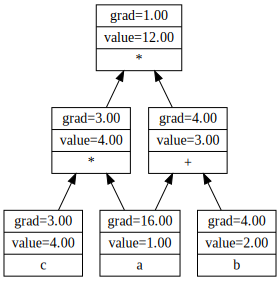

In [20]:
draw_graph(f)

In [30]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../ch07_autograd')))
from utils import Scalar, draw_graph

In [31]:
a = Scalar(1.0, label='a')
b = Scalar(2.0, label='b')
c = Scalar(4.0, label='c')
d = a + b
e = a * c
f = d * e
backward_process = f.backward(draw_graph)

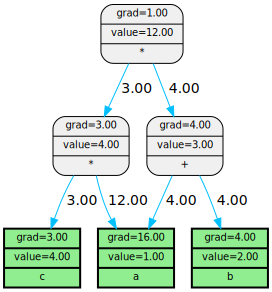

In [32]:
draw_graph(f, 'backward')

In [36]:
!pip install IPython

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [37]:
from IPython.display import clear_output
import time

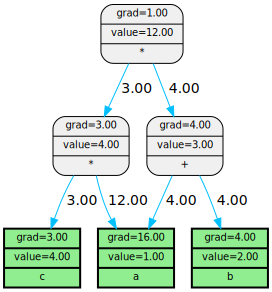

In [39]:
for i in backward_process:
    display(i)
    time.sleep(3)
    clear_output(wait=True)